In [1]:
cd ..

/home/mars/src_aiai


In [2]:
from src.util import gpu_setup
gpu_setup()

8 actual GPUs, 1 in use.


In [3]:
from src.sampling.uv_sampling import spider_sampling, random_sampling

In [4]:
from src.operators.NUFFT2D_TF import NUFFT2D_TF


In [5]:
from src.data import load_M51

In [6]:
import numpy as np
import tensorflow as tf

In [7]:
x = load_M51()
x /= x.max()


In [8]:
Nd = x.shape
Kd = (x.shape[0]*2, x.shape[1]*2)
Jd = (6,6)
batch_size = 1

uv = random_sampling(1000)

In [9]:
nufft_op = NUFFT2D_TF()
nufft_op.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 1502.39it/s]


In [23]:
random_sel = np.random.randint(0,2, size=len(uv)).astype(bool)

In [24]:
%%time
y_sub = nufft_op.dir_op_sub( x, random_sel)

CPU times: user 462 ms, sys: 367 ms, total: 829 ms
Wall time: 1.69 s


In [25]:
%%time
y = nufft_op.dir_op(x)

CPU times: user 7.53 ms, sys: 2.17 ms, total: 9.7 ms
Wall time: 15.6 ms


In [26]:
%%time
x_sub = nufft_op.adj_op_sub(y_sub, random_sel)

CPU times: user 457 ms, sys: 2.17 s, total: 2.63 s
Wall time: 5.27 s


In [27]:
%%time
x_full = nufft_op.adj_op(y)

CPU times: user 5.16 ms, sys: 4.08 ms, total: 9.24 ms
Wall time: 9.36 ms


In [28]:
import matplotlib.pyplot as plt

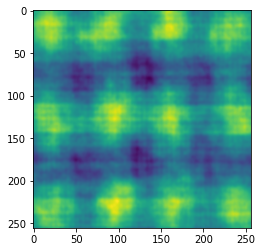

In [29]:
plt.imshow(x_sub.numpy()[0].real)

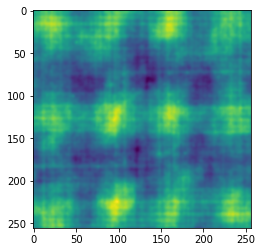

In [30]:
plt.imshow(x_full.numpy()[0].real)

# var datasets

In [10]:
batch_size = 20


In [11]:
operator = "NUFFT_Random"
epochs = 2

In [12]:
class X(tf.data.Dataset):
    """a dataset that loads pre-augmented data. """

    @staticmethod
    def _generator(epochs, operator="NUFFT_SPIDER", ISNR=30):
        i = 0
        try:
            operator = operator.decode('utf-8')
        except:
            pass
        while True:
            x = np.load(f"./data/intermediate/COCO/{operator}/x_true_train_{ISNR}dB_{i:03d}.npy")
          
            yield x
            i = (i + 1) % 100 # only a 100 presaved so reuse them

    def __new__(cls, operator, ISNR=30, epochs=100):
        # assert os.path.exists(
            # f"./data/intermediate/COCO/{operator}" ), \
            # f"Could not find pregenerated dataset for operator {operator}"
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.float32),
            args=(epochs, operator, ISNR)
        )
    
class Y(tf.data.Dataset):
    """a dataset that loads pre-augmented data. """

    @staticmethod
    def _generator(epochs, operator="NUFFT_SPIDER", ISNR=30):
        i = 0
        try:
            operator = operator.decode('utf-8')
        except:
            pass
        while True:
            y = np.load(f"./data/intermediate/COCO/{operator}/y_dirty_train_{ISNR}dB_{i:03d}.npy")
            yield y
            i = (i + 1) % 100 # only a 100 presaved so reuse them

    def __new__(cls, operator, ISNR=30, epochs=100):
        # assert os.path.exists(
            # f"./data/intermediate/COCO/{operator}" ), \
            # f"Could not find pregenerated dataset for operator {operator}"
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.complex64),
            args=(epochs, operator, ISNR)
        )
    
class Z(tf.data.Dataset):
    """a dataset that loads pre-augmented data. """

    @staticmethod
    def _generator(epochs, operator="NUFFT_SPIDER", ISNR=30):
        i = 0
        try:
            operator = operator.decode('utf-8')
        except:
            pass
        while True:
            z = np.load(f"./data/intermediate/COCO/{operator}/sel_train_{ISNR}dB_{i:03d}.npy")
            yield z
            i = (i + 1) % 100 # only a 100 presaved so reuse them

    def __new__(cls, operator, ISNR=30, epochs=100):
        # assert os.path.exists(
            # f"./data/intermediate/COCO/{operator}" ), \
            # f"Could not find pregenerated dataset for operator {operator}"
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.bool),
            args=(epochs, operator, ISNR)
        )

In [13]:
x_dataset = X(
    operator=operator +"_var", epochs=epochs
    ).unbatch()

y_dataset = Y(
    operator=operator +"_var", epochs=epochs
    ).unbatch()

z_dataset = Z(
    operator=operator +"_var", epochs=epochs
    ).unbatch()

In [14]:
yz = tf.data.Dataset.zip((y_dataset, z_dataset))

yzx = tf.data.Dataset.zip((yz, x_dataset)).batch(batch_size)

# unet test

In [36]:
del nufft_op

In [19]:
del model
tf.keras.backend.clear_session()

NameError: name 'model' is not defined

In [20]:
tf.keras.backend.clear_session()

In [21]:
from src.networks.UNet_var import UNet_var


In [33]:
uv = np.load("./data/intermediate/COCO/NUFFT_Random_var/uv_big.npy")

In [34]:
model = UNet_var(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=2, 
    conv_layers=1,
    input_type="measurements", 
    measurement_weights=1,
    batch_size=batch_size,
    residual=True
    )


100%|██████████| 65536/65536 [00:39<00:00, 1647.45it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 65536), dtype=tf.complex64, name='input_3'), name='input_3', description="created by layer 'input_3'") KerasTensor(type_spec=TensorSpec(shape=(20, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_1/AddV2:0', description="created by layer 'tf.__operators__.add_1'")


In [36]:
print(batch_size)
model.fit(yzx, steps_per_epoch=2000//batch_size, epochs=2)

20
Epoch 1/2
100/100 [==============================] - 24s 88ms/step - loss: 0.1219
Epoch 2/2
100/100 [==============================] - 20s 83ms/step - loss: 0.0372


# GUNet test

In [15]:
from src.networks.GUNet_var import GUNet_var


In [67]:
del model
tf.keras.backend.clear_session()

In [39]:
nufft_op.n_measurements, nufft_op.batch_size, 

(1000, 20)

In [20]:
class sub_Gradient(tf.keras.layers.Layer):
    """
    Gradient operator
    TODO create docstring
    """
    def __init__(self, m_op, shape_x, shape_y, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.bool,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    
    def __call__(self, x, y, sel, measurement_weights=1):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.dir_op_sub(x, tf.reshape(sel[0], [-1]))
        res = tf.math.subtract(m,  y)
        grad = self.m_op.adj_op_sub(y , tf.reshape(sel[0], [-1]))
        grad = tf.cast(grad, tf.float32)
        return grad

In [ ]:
def forward(tf.keras.layers.Layer):
    

In [21]:
g = sub_Gradient(nufft_op, (256,256), (1000,), 0)

inputs = tf.keras.Input([nufft_op.n_measurements], dtype=tf.complex64)
sel = tf.keras.Input([nufft_op.n_measurements], dtype=tf.bool)

y_sub = tf.boolean_mask(inputs , sel[0], axis=1)

im = tf.math.real(nufft_op.adj_op_sub(y_sub, tf.reshape(sel[0], [-1])))

im2 = g(im,y_sub,sel)
# y_2 = nufft_op.dir_op_sub(im, tf.reshape(sel[0], [-1]))

# im2 = tf.math.real(nufft_op.adj_op_sub(y_2, tf.reshape(sel[0], [-1])))

outputs = im2

In [80]:
outputs.shape

TensorShape([20, 256, 256])

In [22]:
model = tf.keras.Model(inputs=[inputs, sel], outputs=outputs)
model.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [23]:
model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'model/tf.scatter_nd_4/ScatterNd' defined at (most recent call last):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
      yield self.process_one()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
      return runner(coro)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-23-4e96c2103b5a>", line 1, in <module>
      model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model/tf.scatter_nd_4/ScatterNd'
Detected at node 'model/tf.scatter_nd_4/ScatterNd' defined at (most recent call last):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
      yield self.process_one()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
      return runner(coro)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-23-4e96c2103b5a>", line 1, in <module>
      model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model/tf.scatter_nd_4/ScatterNd'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Dimensions [0,1) of indices[shape=[1179612,3]] must match dimensions [0,1) of updates[shape=[23592240]]
	 [[{{node model/tf.scatter_nd_4/ScatterNd}}]]
	 [[mean_squared_error/cond/then/_0/mean_squared_error/cond/cond/then/_25/mean_squared_error/cond/cond/remove_squeezable_dimensions/cond/pivot_t/_67/_69]]
  (1) INVALID_ARGUMENT:  Dimensions [0,1) of indices[shape=[1179612,3]] must match dimensions [0,1) of updates[shape=[23592240]]
	 [[{{node model/tf.scatter_nd_4/ScatterNd}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4874]

In [103]:

import numpy as np
import tensorflow as tf

class sub_Gradient(tf.keras.layers.Layer):
    """
    Gradient operator
    TODO create docstring
    """
    def __init__(self, m_op, shape_x, shape_y, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.bool,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    
    def __call__(self, x, y, sel, measurement_weights=1):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.dir_op_sub(x, tf.reshape(sel[0], [-1]))
        res = m -  y
        grad = self.m_op.adj_op_sub(y , tf.reshape(sel[0], [-1]))
        grad = tf.cast(grad, tf.float32)
        return grad

def conv_block(x, conv_layers, filters, kernel_size, activation, name):
    for j in range(conv_layers):
        x = tf.keras.layers.Conv2D(
            filters=filters, 
            kernel_size=kernel_size, 
            # activation=activation, 
            padding='same',
            name=name + "_conv2d_" + str(j)
        )(x)
        x = tf.keras.layers.BatchNormalization(
            name=name + "_batchnorm_" + str(j)
        )(x)
        x = tf.keras.layers.ReLU()(x)
    return x 


class GUNet_var(tf.keras.Model):
    def __init__(
        self, 
        image_shape, 
        uv, 
        op=None,
        depth=2, 
        start_filters=16,
        measurement_weights=1,
        conv_layers=1, 
        kernel_size=3, 
        output_activation='linear', 
        input_type="measurements",
        residual = True,
        batch_size=20
        ):

        # store parameters
        self.image_shape = image_shape
        self.uv = uv
        self.depth = depth
        self.start_filters = start_filters
        self.measurement_weights = measurement_weights
        self.conv_layers = conv_layers
        self.kernel_size = kernel_size 
        self.output_activation = output_activation
        self.input_type = input_type
        self.batch_size = batch_size
        self.op = op
        self.residual = residual

        assert not tf.executing_eagerly(), "GUNet cannot be run in eager execution mode, make sure to disable eager execution using `tf.compat.v1.disable_eager_execution()`"
        if self.measurement_weights is None:
            self.measurement_weights = np.ones(len(uv))

        Nd = (image_shape[0], image_shape[1])
        Kd = (Nd[0]*2, Nd[1]*2)
        Jd = (6,6)

        ops = [] # list with measurement operators for each scale
        low_freq_sels = [] # list with frequency measurements for each scale
        freq_weights = [self.measurement_weights]  # list with weights for each scale
        grad_layers = []
        subsampled_inputs = []
        subsampled_selections = []
        
        for i in range(depth+1):
            m_op = self.op() # TF native operator
            nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
            sel =  np.all(uv <  np.pi / 2**i, axis=1) # square selection (with exclusion region outside)

            new_uv = uv[sel]
            m_op.plan(new_uv*2**i, nd, kd, Jd, batch_size) # correct uv so they fill full plane of sub-sample

            freq_weights.append(freq_weights[0][sel])


            low_freq_sels.append(sel)
            ops.append(m_op)

        freq_weights = freq_weights[1:]



        if input_type == "image":
            inputs = tf.keras.Input(image_shape, dtype=tf.float32)
            x = inputs
        elif input_type == "measurements":
            assert op is not None, "Operator needs to be specified when passing measurements as input" 
#             inputs = tf.keras.Input([ops[0].n_measurements], dtype=tf.complex64)
#             x = tf.math.real(ops[0].adj_op(inputs * freq_weights[0]))
            inputs = tf.keras.Input([ops[0].n_measurements], dtype=tf.complex64)
            sel = tf.keras.Input([ops[0].n_measurements], dtype=tf.bool)
            
            y_sub = tf.boolean_mask(inputs * measurement_weights, sel[0], axis=1)
#             x = tf.math.real(m_op.adj_op_sub(inputs * measurement_weights), sel)
            x = tf.math.real(ops[0].adj_op_sub(y_sub, tf.reshape(sel[0], [-1])))
            
        else:
            raise ValueError("argument input_type should be one of ['image', 'measurements']")

        for i in range(depth+1): 
            subsampled_input = tf.boolean_mask(inputs, low_freq_sels[i], axis=1)
            subsampled_input.set_shape([batch_size, np.sum(low_freq_sels[i])])         
            subsampled_inputs.append(subsampled_input)

            subsampled_selection = tf.boolean_mask(sel, low_freq_sels[i], axis=1)
            subsampled_selection.set_shape([batch_size, np.sum(low_freq_sels[i])])         
            subsampled_selections.append(subsampled_selection)
            
            
            grad = sub_Gradient(
                ops[i], 
                shape_x=(Nd[0]//2**(i),Nd[0]//2**(i)), 
                shape_y=(subsampled_inputs[i].shape[0],2), 
                depth=i, 
                )
            grad_layers.append(grad)


        skips = []
  
        x_init = x
        x = tf.expand_dims(x, axis=3) # add empty dimension for CNNs

        conv_kwargs = {
            "kernel_size": kernel_size,
            "activation": "relu",
            "padding": "same",
            }

        # x = self._grad_block(x, grad_layers, subsampled_inputs[0], 0, freq_weights[0]) # calculate and concatenate gradients
        x = tf.keras.layers.Conv2D(filters=start_filters, **conv_kwargs)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # convolution downward
        for i in range(depth):
            if i != 0:
                x = self._grad_block(x, grad_layers, subsampled_inputs[i], subsampled_selections[i], i, freq_weights[i])     
     
            x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(i), # #filters increase with depth
                **conv_kwargs
            )
            skips.append(x)
            x = tf.keras.layers.MaxPool2D(padding='same')(x)


        # Lowest scale
        x = self._grad_block(x, grad_layers, subsampled_inputs[depth], subsampled_selections[depth], depth, freq_weights[depth])
        x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(depth), 
                **conv_kwargs
            )

        # convolutions upward
        for i in range(depth):
            x = tf.keras.layers.Conv2DTranspose(
                filters=start_filters*2**(depth-(i+1)), # #filters increase with depth
                strides=(2,2),
                **conv_kwargs
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
            # x = tf.keras.layers.ReLU()(x)

            # if i == depth-1:
            if i != 0:
                x = self._grad_block(x, grad_layers, subsampled_inputs[depth-(i+1)], subsampled_selections[depth-(i+1)], depth-(i+1), freq_weights[depth-(i+1)])            

            x = tf.keras.layers.Concatenate()([x,skips[depth-(i+1)]])

            x = self._convolutional_block(
                x, 
                conv_layers = conv_layers, 
                filters = start_filters*2**(depth-(i+1)), 
                **conv_kwargs
            )

        x = tf.keras.layers.Conv2D(
                    filters=1, 
                    kernel_size=1, 
                    padding='same',
                    activation=output_activation,
                    name="conv2d_output"
                    )(x)

        # remove extra dimension and add initial reconstruction
        if self.residual:
            outputs = tf.squeeze(x, axis=-1) + x_init 
        else:
            outputs = tf.squeeze(x, axis=-1)


        super().__init__(inputs=[inputs, sel], outputs=outputs)
        print(inputs, outputs)
        self.compile(optimizer='adam', loss= tf.keras.losses.MSE)

    @staticmethod
    def _convolutional_block(x, conv_layers, filters, **conv_kwargs):
        for j in range(conv_layers):
            x = tf.keras.layers.Conv2D(
                filters=filters,
                **conv_kwargs
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
        return x

    @staticmethod
    def _grad_block(x_, grad_layers, y, sel, i, freq_weights=1):
        with tf.name_scope("grad_" + str(i)):
            dirty_im = tf.expand_dims(tf.math.real(grad_layers[i].m_op.adj_op_sub(y, tf.reshape(sel[0], [-1]))), axis=3)

            filtered_grad = tf.expand_dims(grad_layers[i](x_[:,:,:,0], y, sel, measurement_weights=freq_weights), axis=3)
            # if the weights are not uniform, add a non-weighted gradient
            if np.any(freq_weights != np.ones(len(freq_weights))):
                grad = tf.expand_dims(grad_layers[i](x_[:,:,:,0], y, sel, measurement_weights=1), axis=3)
                # return tf.concat([x_[:,:,:,:], grad, filtered_grad], axis=3)
                # return tf.concat([x_[:,:,:,:], dirty_im, grad, filtered_grad], axis=3)
                x_ = tf.concat([x_[:,:,:,:], grad, filtered_grad, dirty_im], axis=3)
                x_ = tf.keras.layers.Conv2D(16*2**(4-(i+1)), kernel_size=3, padding='same', activation='relu')(x_) #TODO remove hardcoded depth=4
                return x_

            else: 
                return tf.concat([x_[:,:,:,:], filtered_grad], axis=3)

    def rebuild_with_op(self, uv):
        """Rebuilds the current network with a new sampling distribution

        Args:
            uv : new sampling distribution

        Returns:
            model : model rebuild with new sampling distribution
        """
        # extract weights from current model
        weigths = [self.layers[i].get_weights() for i in range(len(self.layers))]

        # reset graph and make new model with same parameters but new sampling distribution
        tf.keras.backend.clear_session()
        model = GUnet(
            self.image_shape, 
            uv,
            op=self.op, 
            depth=self.depth, 
            start_filters=self.start_filters,
            conv_layers=self.conv_layers, 
            kernel_size=self.kernel_size, 
            output_activation=self.output_activation, 
            input_type=self.input_type, 
            measurement_weights=self.measurement_weights,
            batch_size=self.batch_size,
            residual=self.residual
        )
        
        # transfer old weights to new model
        for i in range(len(self.layers)):
            model.layers[i].set_weights(weigths[i])
        
        return model

In [20]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


In [16]:
model = GUNet_var(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=1, 
    conv_layers=1,
    input_type="measurements", 
    measurement_weights=np.ones(len(uv)),
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 862/862 [00:00<00:00, 1527.73it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 1000), dtype=tf.complex64, name='input_1'), name='input_1', description="created by layer 'input_1'") KerasTensor(type_spec=TensorSpec(shape=(20, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add/AddV2:0', description="created by layer 'tf.__operators__.add'")


In [18]:
model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'gu_net_var/tf.math.multiply/Mul' defined at (most recent call last):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
      yield self.process_one()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
      return runner(coro)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-17-4e96c2103b5a>", line 1, in <module>
      model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'gu_net_var/tf.math.multiply/Mul'
Detected at node 'gu_net_var/tf.math.multiply/Mul' defined at (most recent call last):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
      yield self.process_one()
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
      return runner(coro)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-17-4e96c2103b5a>", line 1, in <module>
      model.fit(yzx, steps_per_epoch=200//batch_size, epochs=2)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'gu_net_var/tf.math.multiply/Mul'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  required broadcastable shapes
	 [[{{node gu_net_var/tf.math.multiply/Mul}}]]
	 [[mean_squared_error/cond/else/_1/mean_squared_error/cond/remove_squeezable_dimensions/cond/pivot_f/_73/_59]]
  (1) INVALID_ARGUMENT:  required broadcastable shapes
	 [[{{node gu_net_var/tf.math.multiply/Mul}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3679]

# check generation results

In [7]:
a = np.load("./data/intermediate/COCO/NUFFT_Random_var/x_true_test_30dB.npy")
b = np.load("./data/intermediate/COCO/NUFFT_Random_var/y_dirty_train_30dB_000.npy")
c = np.load("./data/intermediate/COCO/NUFFT_Random_var/sel_train_30dB_000.npy")

In [9]:
a.shape, b.shape, c.shape

((1000, 256, 256), (2000, 65536), (2000, 65536))

In [8]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(a[0])

In [ ]:
b[0]

In [ ]:
tf.__version__

In [ ]:
a_set = tf.data.Dataset.from_tensor_slices(a)

In [ ]:
l = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(b[:,:1000]),
    tf.data.Dataset.from_tensor_slices(np.ones_like(b[:,:1000], dtype=bool))
)).batch(20)

In [ ]:
model.predict([b[:,:1000], np.ones_like(b[:,:1000], dtype=bool)], batch_size=20)

In [9]:
c = np.load("./data/processed/COCO/NUFFT_Random_var/test_predict_UNet_var_30dB.npy")

In [10]:
c.shape

(1000, 256, 256)

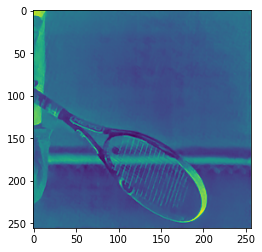

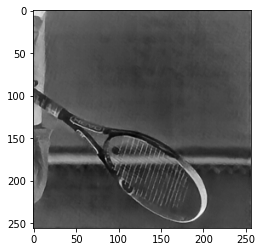

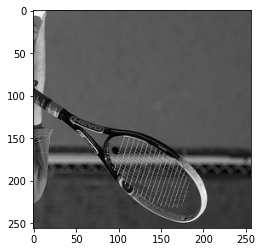

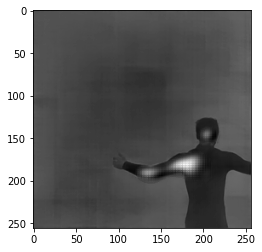

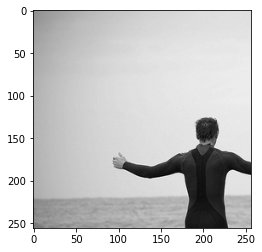

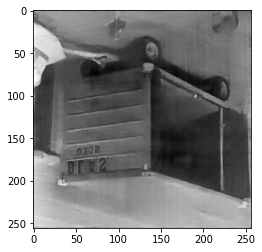

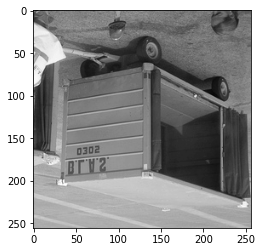

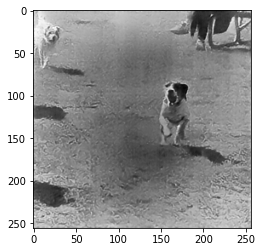

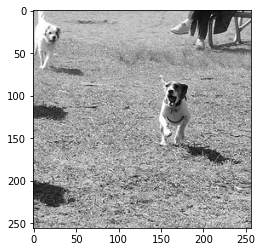

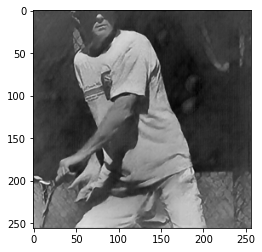

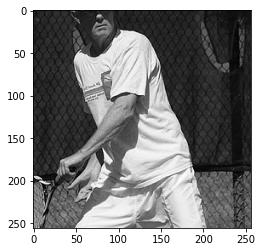

In [19]:
for i in range(5):
    plt.imshow(c[i], cmap='gray')
    plt.show()
    plt.imshow(a[i], cmap='gray')
    plt.show()

In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [16]:
np.mean([peak_signal_noise_ratio(a[i], c[i]) for i in range(len(a))]), np.mean([structural_similarity(a[i], c[i]) for i in range(len(a))])

(13.293152369660318, 0.5408907414925364)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
a = np.loadtxt("../logs/COCO/NUFFT_Random_var/log_GUNet_var_30dB_sub_5", skiprows=1, delimiter=',')
b = np.loadtxt("../logs/COCO/NUFFT_Random/log_GUNet_var_30dB_20x5", skiprows=1, delimiter=',')

In [4]:
def running_mean(x):
    y = []
    

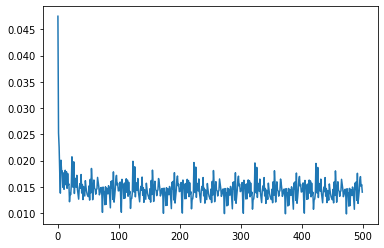

In [5]:
plt.plot(a[:,1])

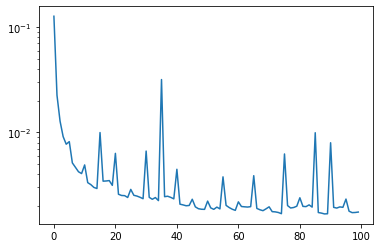

In [7]:
plt.plot(b[:,1])
plt.yscale('log')